In [12]:
library(dplyr)
library(lubridate)
library(ggplot2)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [13]:
data <- read.csv("sp500_2023_2024.csv")

In [14]:
head(data)

,tic,datadate,conm,exchg,sic,cshtrd,prccd,prchd,prcld,prcod,gvkey
,<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,PNW,03/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,1442534,74.63,76.4125,73.380,76.25,1075
2,PNW,04/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,954218,75.39,76.0950,74.630,75.10,1075
3,PNW,05/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,994775,73.65,75.0950,73.305,74.88,1075
4,PNW,06/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,729808,75.46,76.0200,74.480,74.49,1075
5,PNW,09/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,656127,75.55,76.4800,75.240,75.24,1075
6,PNW,10/01/2023,PINNACLE WEST CAPITAL CORP,11,4911,763254,75.65,75.6950,74.880,75.31,1075


In [15]:
# Calculate simple weekly returns for each ticker in the full dataset
weekly_returns <- data %>%
  mutate(datadate = as.Date(datadate, format = "%d/%m/%Y")) %>%
  group_by(tic) %>%
  arrange(datadate) %>%
  mutate(Week = floor_date(datadate, unit = "week")) %>%
  group_by(tic, Week) %>%
  summarise(Weekly_Close = last(prccd)) %>%
  arrange(tic, Week) %>%
  mutate(Weekly_Return = (Weekly_Close / lag(Weekly_Close)) - 1) %>%
  ungroup()

`summarise()` has grouped output by 'tic'. You can override using the `.groups`
argument.


In [17]:
# Categorise your data into decile groups based on simple weekly returns, labelled 0%, 10%, 20%, without removing zeroes
quantile_result <- weekly_returns %>%
  mutate(
    deciles = cut(
      Weekly_Return,
      breaks = quantile(
        Weekly_Return,
        probs = c(0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1),
        type = 5,
        na.rm = TRUE
      ),
      include.lowest = TRUE,
      labels = c("0%", "10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%", "90%")
    )
  )

In [19]:
head(quantile_result)

tic,Week,Weekly_Close,Weekly_Return,deciles
<chr>,<date>,<dbl>,<dbl>,<fct>
A,2023-01-01,147.67,NA,NA
A,2023-01-08,156.92,0.062639670,90%
A,2023-01-15,155.92,-0.006372674,30%
A,2023-01-22,155.69,-0.001475115,40%
A,2023-01-29,154.55,-0.007322243,30%
A,2023-02-05,152.55,-0.012940796,30%


In [24]:
# Display a table showing the top ticker (the ticker with the highest weekly return) in each decile group
top_tickers <- quantile_result %>%
  group_by(deciles) %>%
  filter(Weekly_Return == max(Weekly_Return)) %>%
  select(deciles, tic, Weekly_Return) %>%
  arrange(deciles)
print(top_tickers)

# A tibble: 12 × 3
# Groups:   deciles [10]
   deciles tic   Weekly_Return
   <fct>   <chr>         <dbl>
 1 0%      DVN        -0.0415 
 2 10%     WBD        -0.0248 
 3 20%     CNC        -0.0141 
 4 20%     TRMB       -0.0141 
 5 30%     GLW        -0.00544
 6 30%     PPL        -0.00544
 7 40%     AXP         0.00228
 8 50%     AZO         0.0101 
 9 60%     WDC         0.0185 
10 70%     PPG         0.0292 
11 80%     SJM         0.0470 
12 90%     SMCI        0.784  


In [30]:
# Select the top ticker from the 60% decile group.
top_60_ticker <- top_tickers %>%
  filter(deciles == "60%")
print(top_60_ticker$tic)

[1] "WDC"


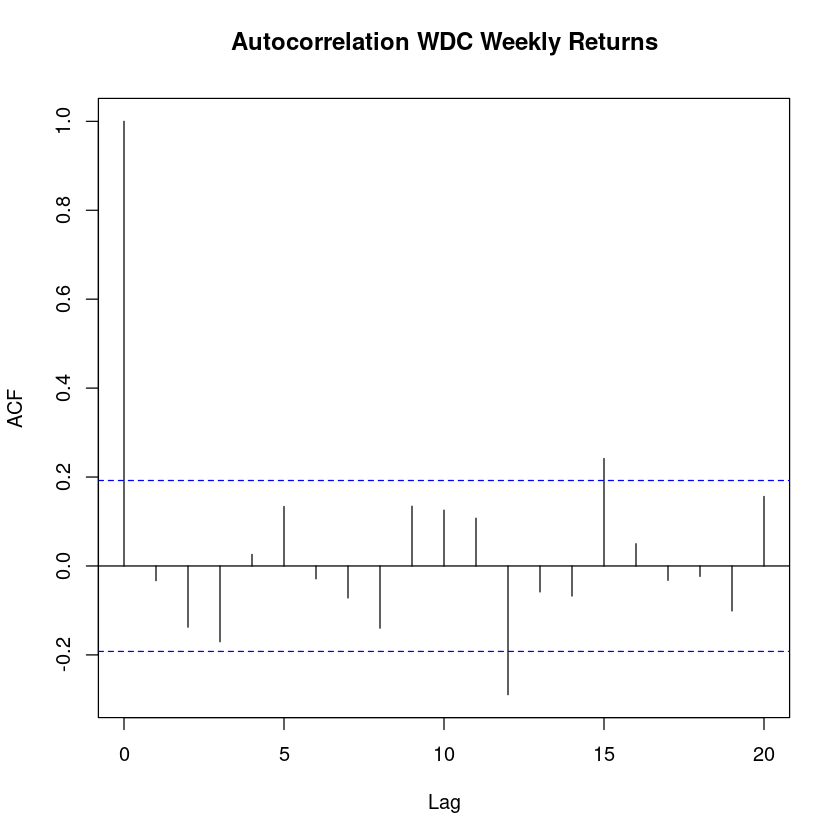

In [35]:
wdc_data <- weekly_returns %>%
  filter(tic == "WDC") %>%
  na.omit()

# Autocorrelate, add a main title
acf(wdc_data$Weekly_Return, main = "Autocorrelation WDC Weekly Returns")